In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
import seaborn as sns 
import warnings 
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from PIL import Image 

### Construction du Dataframe pour l'entraînement

In [2]:
repertoire_age_list=[]
reference_age_list=[]
face_id_age_list=[]
repertoire_gender_list=[]
reference_gender_list=[]
face_id_gender_list=[]
ages = []
genders=[]

chemin_fichier_age = '/kaggle/input/adience-dataset/train_val_txt_files_per_fold/test_fold_is_3/age_train.txt'
with open(chemin_fichier_age, 'r') as fichier_age:
     for ligne in fichier_age:
# Division de la ligne en référence et âge
           elements = ligne.strip().split()
           if len(elements) == 2:  # Assurez-vous qu'il y a deux éléments sur la ligne
                image, age = elements
                repertoire = image.split('/')[0]
                reference=image.split('/')[1]
                face_id = reference.split('.')[1]
                repertoire_age_list.append(repertoire)
                reference_age_list.append(reference)
                face_id_age_list.append(int(face_id))
                ages.append(int(age))  # Convertissez l'âge en entier si nécessaire

chemin_fichier_gender ='/kaggle/input/adience-dataset/train_val_txt_files_per_fold/test_fold_is_3/gender_train.txt'
with open(chemin_fichier_gender, 'r') as fichier_gender:
     for ligne in fichier_gender:
# Division de la ligne en référence et âge
           elements = ligne.strip().split()
           if len(elements) == 2:  # Assurez-vous qu'il y a deux éléments sur la ligne
                image, gender = elements
                repertoire = image.split('/')[0]
                reference=image.split('/')[1]
                face_id = reference.split('.')[1]
                repertoire_gender_list.append(repertoire)
                reference_gender_list.append(reference)
                face_id_gender_list.append(int(face_id))
                genders.append(int(gender))  
                        
data_age = {'Répertoire': repertoire_age_list, 'Reference_image':reference_age_list,'Face_id':face_id_age_list,'Age': ages}
df_age = pd.DataFrame(data_age)
data_gender = {'Répertoire': repertoire_gender_list, 'Reference_image':reference_gender_list,'Face_id':face_id_gender_list, 'Gender': genders}
df_gender = pd.DataFrame(data_gender)

# Retirer 50% des lignes avec l'âge 4 de manière aléatoire
rows_to_remove = df_age[df_age['Age'] == 4].sample(frac=0.5)  
df_age = df_age.drop(rows_to_remove.index).reset_index(drop=True)

In [3]:
df_total = pd.merge(df_age, df_gender[['Face_id', 'Gender']], on=['Face_id']).drop_duplicates().sample(frac=1).reset_index(drop=True)
df_total.head()

,Répertoire,Reference_image,Face_id,Age,Gender
0,20254529@N04,landmark_aligned_face.13.11509520083_b2b5b8d08...,13,4,1
1,10897942@N03,landmark_aligned_face.632.8403735042_836a05deb...,632,4,0
2,28754132@N06,landmark_aligned_face.611.11612663734_7a5ecd6d...,611,5,1
3,33627988@N04,landmark_aligned_face.1948.11642034935_49a0399...,1948,2,1
4,10113099@N03,landmark_aligned_face.448.12039729726_29ed0a4e...,448,2,1


# Analyse des données

### Distribution des âges

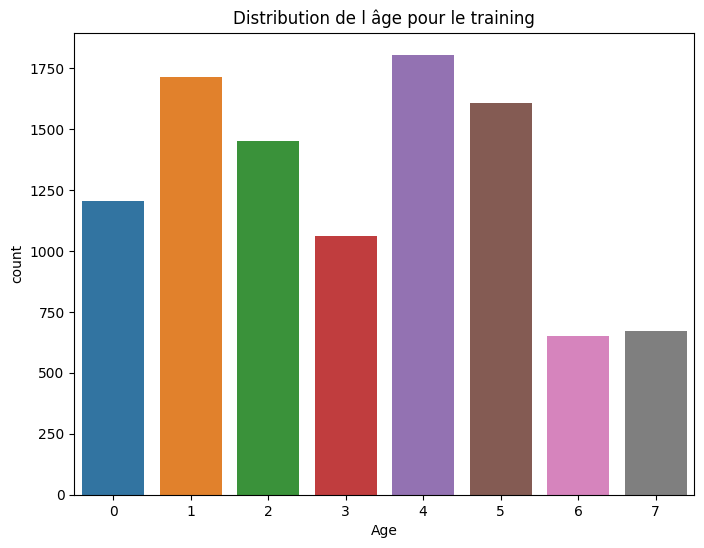

In [4]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Age', data=df_total)
plt.title('Distribution de l âge pour le training')
plt.show()

### Distribution des genres

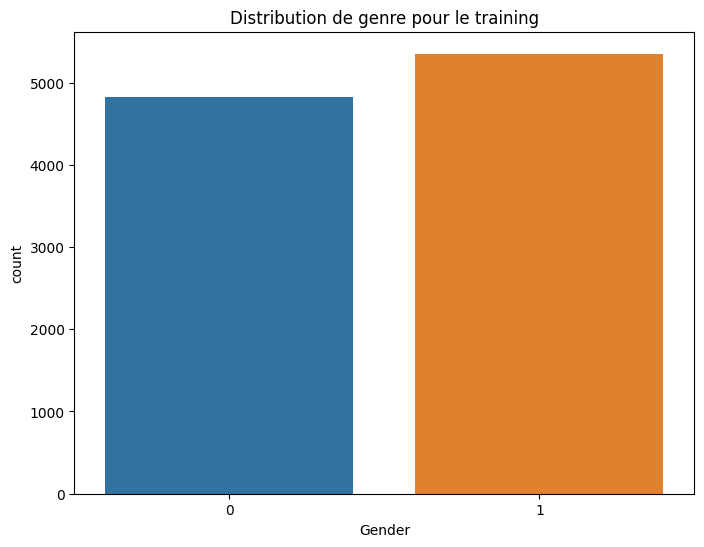

In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=df_total)
plt.title('Distribution de genre pour le training')
plt.show()

# Extraction des caractériqtiques

In [6]:
def extract_features(images):
    features= []
    for image in tqdm(images): 
        img= load_img('/kaggle/input/img-aligned/aligned/'+image)
        img= img.resize((128,128), Image.ANTIALIAS)
        img=np.array(img)
        features.append(img)
        
    features = np.array(features)
    features=features.reshape(len(features),128,128,3)
    return features

In [7]:
features_images= extract_features(df_total['Répertoire']+'/'+df_total['Reference_image'])

  0%|          | 0/10171 [00:00<?, ?it/s]

### Division des données (entraînement et validation) et normalisation

In [8]:

X_train, X_val, y_train, y_val = train_test_split( features_images,to_categorical(df_total['Age']*2 + df_total['Gender'], num_classes=16),test_size=0.2,random_state=42)
#Random state: un paramètre optionnel qui permet de contrôler la randomisation lors de la division des données en ensembles d'entraînement et de validation
#L'utilisation de 42 est souvent une convention dans le domaine de l'informatique
X_train = X_train / 255.0
X_val = X_val / 255.0


# Creation du modèle 

In [9]:

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))  
model.add(Dense(16, activation='softmax'))  


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

### Entrainement de modèle

In [10]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/10
255/255 [==============================] - 66s 253ms/step - loss: 2.5978 - accuracy: 0.1487 - val_loss: 2.2941 - val_accuracy: 0.2324
Epoch 2/10
255/255 [==============================] - 60s 235ms/step - loss: 2.1030 - accuracy: 0.2899 - val_loss: 1.9459 - val_accuracy: 0.3219
Epoch 3/10
255/255 [==============================] - 61s 239ms/step - loss: 1.7799 - accuracy: 0.3980 - val_loss: 1.7387 - val_accuracy: 0.4015
Epoch 4/10
255/255 [==============================] - 60s 235ms/step - loss: 1.5224 - accuracy: 0.4679 - val_loss: 1.6185 - val_accuracy: 0.4432
Epoch 5/10
255/255 [==============================] - 61s 238ms/step - loss: 1.2998 - accuracy: 0.5519 - val_loss: 1.5697 - val_accuracy: 0.4747
Epoch 6/10
255/255 [==============================] - 61s 239ms/step - loss: 1.0970 - accuracy: 0.6137 - val_loss: 1.5761 - val_accuracy: 0.4943
Epoch 7/10
255/255 [==============================] - 60s 235ms/step - loss: 0.9070 - accuracy: 0.6801 - val_loss: 1.6059 - val_ac

### Enregistrement du modèle

In [11]:
model.save('modele_sol2_new.h5')

### Visualisation de l'accuracy pour le modèle

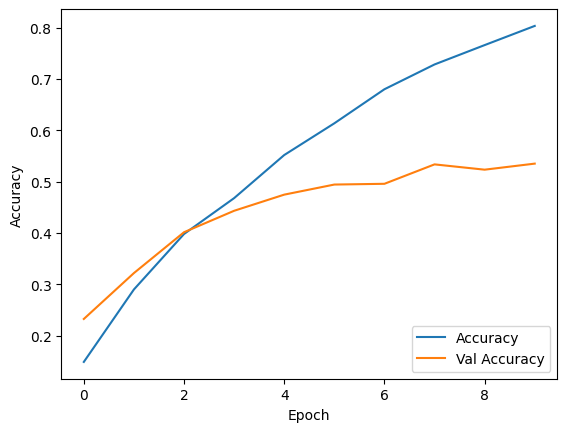

In [12]:

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Visualisation de Loss du modèle

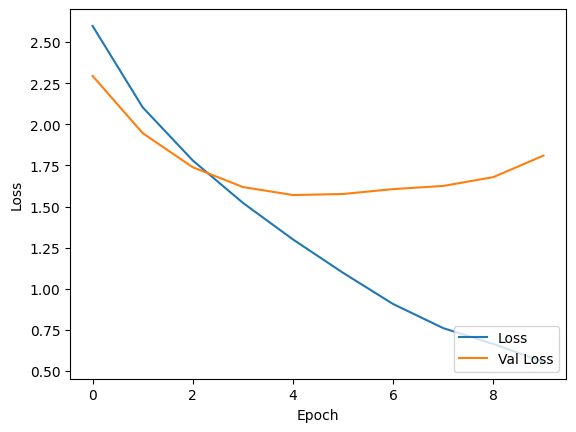

In [13]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend(loc='lower right')
plt.show()